In [8]:
import os

import torch
from torchvision.transforms import v2

import pandas as pd
import numpy as np
import matplotlib

import tqdm.notebook as tqdm

%load_ext autoreload

from training_utils import *
%autoreload 2
from cnn_model import *
%autoreload 2
from data_loaders import *
%autoreload 2

import warnings 
warnings.filterwarnings('ignore', category=UserWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


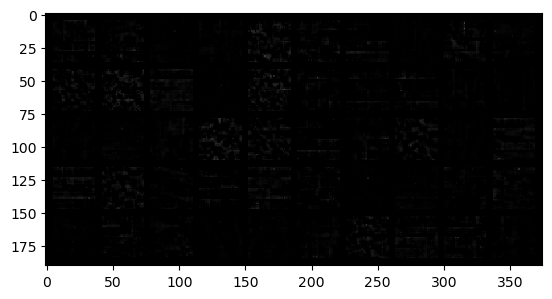

In [9]:
transform = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    # v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    v2.ToDtype(torch.float, scale=True)
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 64
batch_id = 10

img_type = 'raw-derivative.-60'
# img_type = 'raw-original'
# img_type = 'raw-fft'

inference_data = CloudDetectionInference(
    batch_id = batch_id,
    transform = transform
)
inference_loader = torch.utils.data.DataLoader(
  dataset=inference_data,
  batch_size=batch_size
)
images = [inference_data[i][img_type] for i in np.random.choice(len(inference_data), size=50, replace=False)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=10, padding=5).numpy().transpose((1, 2, 0)), vmin=-0.0001, vmax=0.001, cmap='icefire')

In [10]:
os.getcwd()

'/Users/nico/panoseti/panoseti-software/cloud-detection/model_training'

In [14]:
model = CloudDetection()
model.load_state_dict(torch.load('../model_training/best_cloud_detection_model_2-24-24.pth'))
device = get_device()
model.to(device)
with open('../model_training/model_summary.txt', 'r') as f:
    # print(f.read())
    ...

In [15]:
# test_dataloader = torch.utils.data.DataLoader(testing_data, batch_size=64, shuffle=False)
# Store a numpy vector of the predictions for the test set in the variable `predictions`.
predictions = np.array([], dtype=int)
true_labels = []
with torch.no_grad():
    model.eval() # Put model in eval mode
    for img_data in tqdm.tqdm(inference_loader, unit="batch"):
        x = img_data[img_type]
        x = x.float().to(device)
        pred = model(x)
        # predictions = torch.cat((predictions, torch.argmax(pred, dim=1)))
        predictions = np.concatenate((predictions, torch.argmax(pred, dim=1).to('cpu').numpy()))
print(predictions)

  0%|          | 0/2 [00:00<?, ?batch/s]

[1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [16]:
inference_data.inference_session.add_labels(predictions)

In [48]:
import sys
sys.path.append('../dataset_construction')
from pano_utils import *
from panoseti_file_interfaces import ObservingRunInterface
from IPython import display
from time import sleep

In [49]:
get_path = inference_data.inference_session.get_pano_feature_fpath

In [50]:
labeled = inference_data.inference_session.labeled_df
cloudy = labeled[labeled['label'] == 'not_clear_cloudy']
clear = labeled[labeled['label'] == 'clear_night_sky']

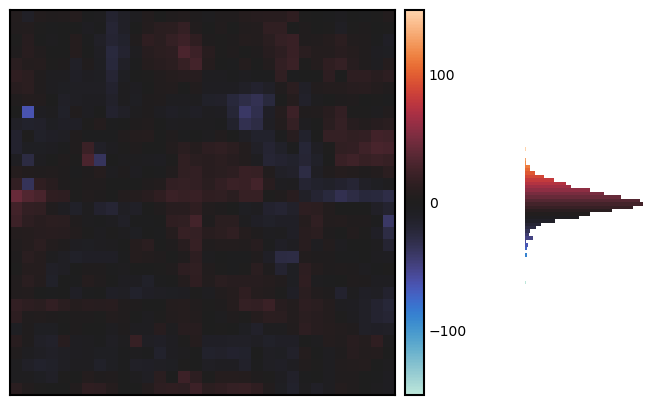

In [58]:
for fuid in cloudy['feature_uid']:
    data = np.load(get_path(fuid, img_type), allow_pickle=False)
    ObservingRunInterface.plot_image(
        data, bins=40, vmin=-150, vmax=150, cmap='icefire', perc=(0.5, 99.5)
    )
    display.clear_output(wait=True)
    plt.show()
    # i = input()
    plt.close()
    sleep(0.3)
    # if i != 'y':
        # break